# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (morfemy). W przeciwieństwie do podejść lingwistycznych, wymagających reguł tworzenia morfemów, BPE wyznacza je automatycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków które występują obok siebie.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20) razy
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10) razy
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technike BPE na tych słowach.

Zaimplementuj algorytm BPE wykonujący `number_of_iterations` iteracji (łączeń symboli).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [72]:
import pandas as pd
import numpy as np
from collections import Counter
brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])

END_SYMBOL = 'END'
number_of_iterations = 10


def concatenate_words(splitted_word, first_elem, second_elem, concatenated):
    # Preapre output
    result = list()
    
    # Last seen element
    last_seen_elem = None
    
    for elem in splitted_word:
        if last_seen_elem is not None:
            # We must check both elements
            if last_seen_elem == first_elem and elem == second_elem:
                # Add concatenated word to result
                result.append(concatenated)
                
                # Clear last element to prevent duplications in replacement
                last_seen_elem = None
                
                # Check next element
                continue
            else:
                # Store previous element
                result.append(last_seen_elem)
            
        # Update last seen element
        last_seen_elem = elem
        
    # Add last element if not paired
    if last_seen_elem is not None:
        result.append(last_seen_elem)
        
    # Return joined list
    return result


def add_end_tag(splitted_word):
    splitted_word.append(END_SYMBOL)
    return splitted_word


def output(df):
    """
    Generate output as list of words, each with <END> tag
    """
    return df['word'].apply(lambda word: ' '.join(word)).tolist()
    

def preform_bpe(brown_df, number_of_iterations):
    """
    Funkcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    # Copy dataframe
    df = brown_df.copy()
    
    # Ensure word is string
    df['word'] = df['word'].astype(str)
    
    # Split each character
    df['word'] = df['word'].apply(lambda word: list(word))
    
    # Add <END> tag
    df['word'] = df['word'].apply(add_end_tag)
    
    # Do it n-times
    for _iteration in range(number_of_iterations):
        # Vocabulary counter - we will use it to find the best pair
        vocabulary = Counter()

        # Iterate over elements in corpus
        for row in df.itertuples():
            last_element = None
            for element in row.word:
                if last_element is not None:
                    # We already seen element - can generate new pair
                    vocabulary[(last_element, element)] += row.count

                # Update last seen element
                last_element = element
            
        # Now we must ensure at least one pair found
        if not vocabulary:
            return output(df)

        # We can find maximum element
        ((first_elem, second_elem), cardinality) = vocabulary.most_common(1)[0]
        concatenated = first_elem + second_elem
        print(first_elem + ' AND ' + second_elem + ' ====> ' + concatenated)
    
        # Update words - join group 
        df['word'] = df['word'].apply(concatenate_words, args = (first_elem, second_elem, concatenated))
    
    # Return dataframe
    return output(df)

Test implementacji:

In [73]:
from nose.tools import assert_list_equal
data = {'cluster': range(2), 'word':['ala', 'mama'], 'count': [5,10]}
df = pd.DataFrame (data, columns = ['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

m AND a ====> ma


Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [74]:
preform_bpe(brown_df, 50)

e AND END ====> eEND
t AND END ====> tEND
s AND END ====> sEND
i AND n ====> in
t AND h ====> th
d AND END ====> dEND
y AND END ====> yEND
. AND END ====> .END
o AND END ====> oEND
r AND END ====> rEND
a AND n ====> an
> AND END ====> >END
o AND n ====> on
o AND u ====> ou
g AND END ====> gEND
a AND END ====> aEND
l AND END ====> lEND
in AND gEND ====> ingEND
< AND @ ====> <@
<@ AND M ====> <@M
<@M AND E ====> <@ME
<@ME AND N ====> <@MEN
<@MEN AND T ====> <@MENT
<@MENT AND I ====> <@MENTI
<@MENTI AND O ====> <@MENTIO
<@MENTIO AND N ====> <@MENTION
<@MENTION AND >END ====> <@MENTION>END
r AND e ====> re
i AND END ====> iEND
th AND eEND ====> theEND
e AND n ====> en
o AND m ====> om
t AND oEND ====> toEND
, AND END ====> ,END
! AND END ====> !END
e AND r ====> er
h AND a ====> ha
e AND rEND ====> erEND
i AND t ====> it
: AND END ====> :END
y AND ou ====> you
a AND r ====> ar
a AND l ====> al
o AND r ====> or
o AND w ====> ow
. AND .END ====> ..END
s AND t ====> st
k AND END ====> kEND
i 

['\\ iEND',
 '/ i / END',
 't o d a y - iEND',
 'n ow iEND',
 '# you e v erEND',
 'i f in al l yEND',
 '「 iEND',
 '- i - END',
 'in e v aEND',
 '» iEND',
 'w ha t t a y aEND',
 'i i i i i i i i i iEND',
 '\ue6d1 END',
 'i k in d aEND',
 'l o l - iEND',
 'i a c t u al l yEND',
 'w a d d y aEND',
 '# a s l on g a s you END',
 'd o you END',
 '\u200e \u200b iEND',
 'i ̇ END',
 'ï END',
 '# l o l a t g i r l s w h oEND',
 '# r t i f you END',
 'i j s tEND',
 '« iEND',
 '• iEND',
 'w h o d aEND',
 'w ha d y aEND',
 ') iEND',
 '+ iEND',
 '# you r f a c e m a k e s m eEND',
 'i i i i i i i iEND',
 '` iEND',
 'i i i i i i iEND',
 'i al re a d yEND',
 '_ iEND',
 '# you m a k e m eEND',
 '* iEND',
 '| iEND',
 '# u r b o y f r i en d e v erEND',
 'w h en iEND',
 'ι END',
 "d on ' t c h aEND",
 "w h o ' d aEND",
 'd you END',
 'w ha d d a y aEND',
 'i on l yEND',
 'i j u s sEND',
 'i al w a y sEND',
 'i i i i iEND',
 'd on c h aEND',
 '( iEND',
 "d ' y aEND",
 'ı END',
 '# u e v erEND',
 'in e v e

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

in

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji (problem OOV, odnieś się do  k-gramów i n-gramów)?

Możemy zaobserwować następujące zalety:
* kompresja danych dzięki redukcji powtarzających się ciągów znaków do specjalnych symboli. Dodatkowo istnieje przekształcenie odwrotne więc operacja nie będzie stratna.
* zapewnia że popularne słowa będą reprezentowane jako jeden token, podczas gdy mniej popularne będą powstawać ze zlepień kilku tokenów
* w przypadku k-gramów reprezentuje najpopularniejsze jako osobne tokeny, umożliwiając jednocześnie łączenie tokenów tworząc dłuższe ciągi znaków
* moglibyśmy go wykorzystać do n-gramów gdzie zamiast łączenia poszczególnych znaków dokonywalibyśmy łączenia całych wyrazów tworząc częste podsekwencje (złączenie kilku tokenów reprezentujących słowa w jeden token)
* radzi sobie z problemem OOV poprzez rozdzielanie na fragmenty, które zna tj. ma możliwość zastąpienia fragmentu słowa tokenem X a resztę innym tokenem (bądź też pozostawi bez zamiany) co pozwala potencjalnie reprezentować nieznane słowo znanymi wcześniej fragmentami.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [75]:
from helpers import DataSet
training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [76]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz przykłady uczące na cechy rośnie do bardzo dużych rozmiarów nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [77]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import FeatureHasher

# Prepare training data and sentiment label assigned to tweets
tweets = [Counter(tweet.tokens) for tweet in training_set.tweets]
y_train_tweets = [tweet.clazz for tweet in training_set.tweets]

def classify_and_score(n_features = 16, x = tweets, y = y_train_tweets):
    # Prepare separation in data - training and test data
    index = int(len(x) * 0.8)
    
    pipeline = Pipeline([
        ('feature_hasher', FeatureHasher(n_features)),
        ('classifier', SVC())
    ])
    pipeline.fit(x[0:index], y[0:index])

    # Score classifier
    predicted = pipeline.predict(x[index+1:])
    return accuracy_score(predicted, y[index+1:])

classify_and_score()

0.5582034830430798

- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

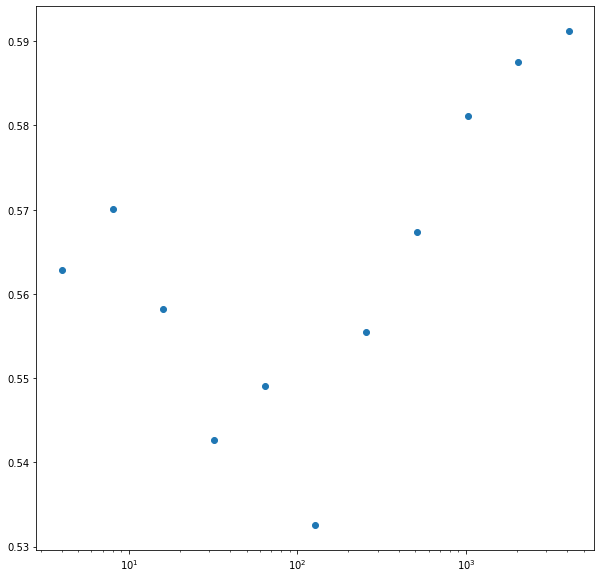

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Scores result and n-features size
scores = list()
n_features_list = 2**np.arange(2, 13)

# Calculate scores
for n_features in n_features_list:
    scores.append(classify_and_score(n_features = n_features))

# Plot
plt.figure(figsize=(10,10))
plt.xscale('log')
plt.xlabel('Liczba cech')
plt.ylabel('Wynik klasyfikacji')
plt.title('Miara klasyfikacji od liczby cech')
plt.plot(n_features_list, scores, linestyle='', marker='o')
plt.show()

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

Zaobserwowano co następuje:
* Już kilka cech pozwala na dobre odzwierciedlenie charakteru danych tj. pozwolić klasyfikatorowi na poprawne działanie - mogą mieć wtedy znaczenie najbardziej istotne atrybuty
* Rozszerzanie cech może wpłynąć negatywnie na rezultat (pogorszyć jakość klasyfikacji) - klasyfikator może mieć problemy z wybraniem najbardziej istotnych cech
* Liczba cech powinna pozwalać na przedstawienie jak największej liczby niezbędnych atrybutów, a jednocześnie nie być zbyt duża - zwiększanie liczby cech może wpłynąć nieznacznie na jakość rozwiązania jednocześnie wydłużając znacząco przetwarzanie
* Skonfliktowane cechy mogą poprawnie należeć "do jednej grupy" tj. promować istotność danego atrybutu, co może być kwintesencją działania algorytmu w przypadku małej liczby cech.

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [94]:
from sklearn.feature_extraction import DictVectorizer

# Prepare translations word to cluster code
word2cluster = { row.word: str(row.cluster) for row in brown_df.itertuples() }

# Translate words in tweets into clusters
clusters = [[word2cluster.get(token, "-1") for token in tweet.tokens] for tweet in training_set.tweets]

# Prepare Bag of cluster representation
data = list()
for codes in clusters:
    dictionary = {}
    for code in codes:
        dictionary[code] = dictionary.get(code, 0) + 1
    data.append(dictionary)

# Separate data - prepare test and train set
index = int(len(clusters) * 0.8)

# Prepare operation pipeline
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', SVC())
])

# Fit classifier
pipeline.fit(data[0:index], y_train_tweets[0:index])

# Predict classes
predicted = pipeline.predict(data[index+1:])

# Check accuracy
accuracy_score(predicted, y_train_tweets[index+1:])

0.5802016498625114

- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

YOUR ANSWER HERE